In [6]:
import sys 
sys.path.append('../src/')
import ANNNIstates as ANNNI

In [7]:
TT = ANNNI.mps(gpu=True)

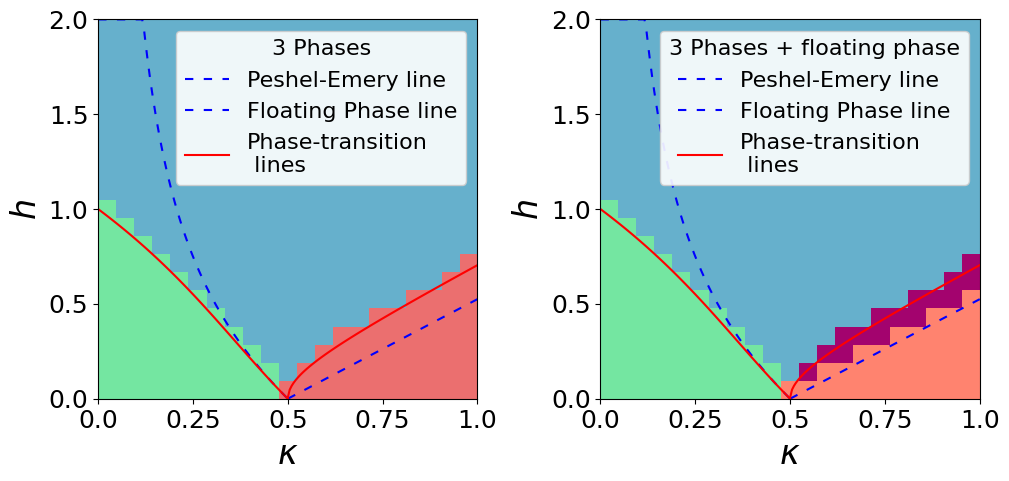

In [8]:
TT.plot_labels()

In [9]:
TT.train3(epochs=1000)

Loss: 0.07286: 100%|██████████| 1000/1000 [00:28<00:00, 34.65it/s]


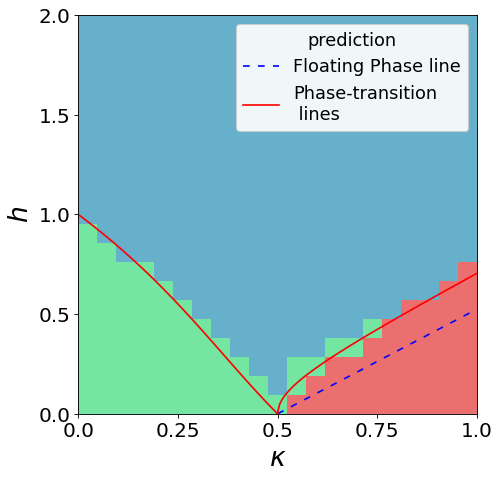

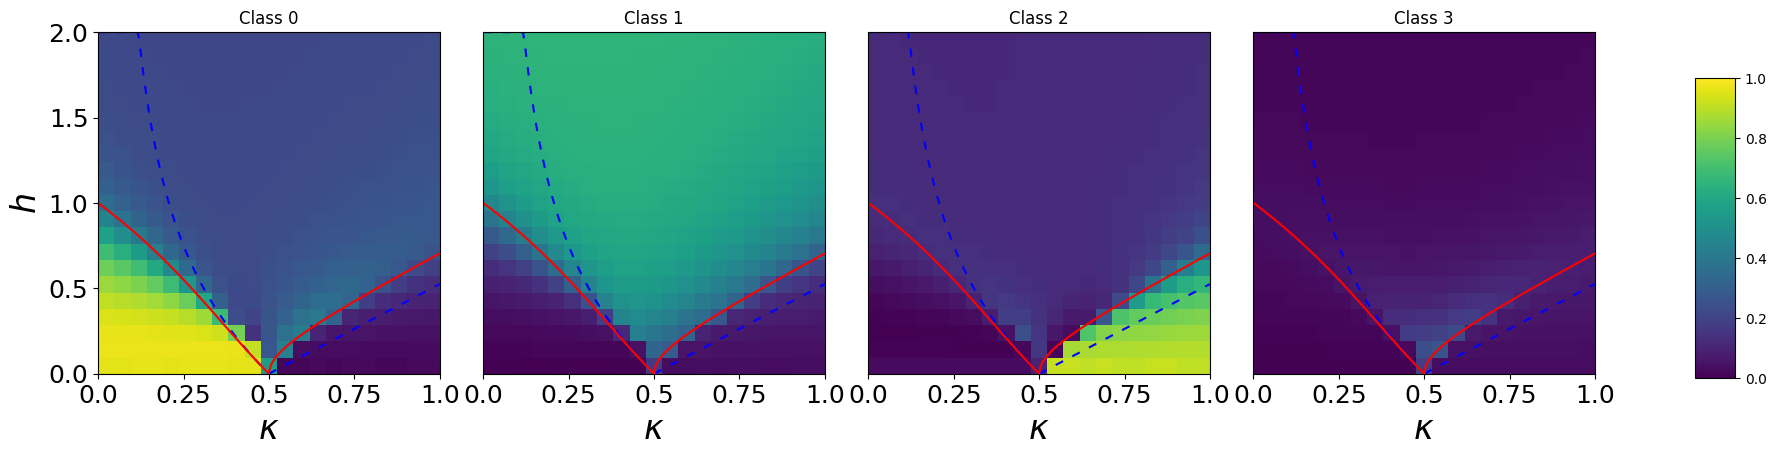

In [10]:
TT.predict(plot=True, eachclass=True)